In [5]:
from dataset import Dataset
import torch
from model import LSTMModel
import matplotlib.pyplot as plt
import os

In [6]:
loss_fn=torch.nn.CrossEntropyLoss()


Epoch:  0 Training Accuracy:  0.34116083296411165
Epoch:  0 Val Accuracy:  0.24185724185724186
Epoch:  1 Training Accuracy:  0.36896322552060257
Epoch:  1 Val Accuracy:  0.2674982674982675
Epoch:  2 Training Accuracy:  0.36984935755427556
Epoch:  2 Val Accuracy:  0.2758142758142758
Epoch:  3 Training Accuracy:  0.3975409836065574
Epoch:  3 Val Accuracy:  0.31046431046431044
Epoch:  4 Training Accuracy:  0.37660611431103236
Epoch:  4 Val Accuracy:  0.2273042273042273
Epoch:  5 Training Accuracy:  0.39499335400974744
Epoch:  5 Val Accuracy:  0.358974358974359
Epoch:  6 Training Accuracy:  0.4212450155073106
Epoch:  6 Val Accuracy:  0.36936936936936937
Epoch:  7 Training Accuracy:  0.4077315019937971
Epoch:  7 Val Accuracy:  0.36174636174636177
Epoch:  8 Training Accuracy:  0.43198936641559593
Epoch:  8 Val Accuracy:  0.3970893970893971
Epoch:  9 Training Accuracy:  0.45159503766061143
Epoch:  9 Val Accuracy:  0.27927927927927926
Epoch:  10 Training Accuracy:  0.48305272485600353
Epoch:  

KeyboardInterrupt: 

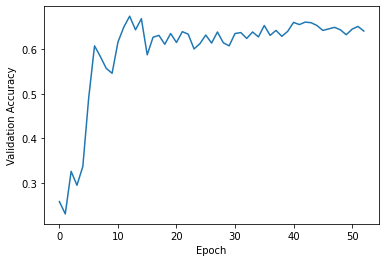

In [7]:
output_classes=6
dropout=0.1
for second in [3,2.5,2,1.5]:
    train=torch.load('train'+str(second)+'_dataloader.pt')
    val=torch.load('val'+str(second)+'_dataloader.pt')
    for layer in [3,4,2]:
            for hidden_dim in [16,32,64]:
                torch.manual_seed(0)
                model=LSTMModel(11,hidden_dim,layer,output_classes,dropout)
                optimizer=torch.optim.AdamW(model.parameters(),lr=0.01)
                scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.3)
                filename='model'+str(second)+'/'+str(layer)+'_'+str(hidden_dim)
                if not os.path.exists(filename):
                    os.makedirs(filename)
                f=open(filename+'/results.txt','w')
                loss_arr=[]
                training_accuracy=[]
                val_accuracy=[]
                for epoch in range(100):
                    model.train()
                    loss_sum=0
                    for i,(x,y) in enumerate(train):
                        optimizer.zero_grad()
                        y_pred=model(x)
                        loss=loss_fn(y_pred,y)
                        loss.backward()
                        optimizer.step()
                        loss_sum+=loss.item()
                    scheduler.step()
                    loss_sum/=len(train)
                    loss_arr.append(loss_sum)
                    model.eval()
                    correct=0
                    total=0
                    #Calculate accuracy per class 
                    accuracy_per_class=[0]*output_classes
                    fp_per_class=[0]*output_classes
                    fn_per_class=[0]*output_classes
                    tp_per_class=[0]*output_classes
                    tn_per_class=[0]*output_classes
                    fp_rate_per_class=[0]*output_classes
                    for i,(x,y) in enumerate(train):
                        y_pred=model(x)
                        _,predicted=torch.max(y_pred.data,1)
                        total+=y.size(0)
                        y=torch.max(y,1)[1]
                        correct+=(predicted==y).sum().item()
                        for i in range(len(y)):
                            if y[i]==predicted[i]:
                                tp_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i]:
                                        tn_per_class[j]+=1
                            else:
                                fp_per_class[predicted[i]]+=1
                                fn_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i] and j!=predicted[i]:
                                        tn_per_class[j]+=1
                    for i in range(output_classes):
                        fp_rate_per_class[i]=fp_per_class[i]/(fp_per_class[i]+tn_per_class[i])
                        accuracy_per_class[i]=tp_per_class[i]/(tp_per_class[i]+fn_per_class[i])
                    print('Epoch: ',epoch,'Training Accuracy: ',correct/total)
                    training_accuracy.append(correct/total)
                    f.write('Epoch: '+str(epoch)+' Training Accuracy: '+str(correct/total)+'\n')
                    f.write('Accuracy per class: '+str(accuracy_per_class)+'\n')
                    f.write('False positive rate per class: '+str(fp_rate_per_class)+'\n')
                    f.write('False positive per class: '+str(fp_per_class)+'\n')
                    f.write('False negative per class: '+str(fn_per_class)+'\n')
                    f.write('True positive per class: '+str(tp_per_class)+'\n')
                    f.write('True negative per class: '+str(tn_per_class)+'\n')
                    f.write('\n')
                    correct=0
                    total=0
                    accuracy_per_class=[0]*output_classes
                    fp_per_class=[0]*output_classes
                    fn_per_class=[0]*output_classes
                    tp_per_class=[0]*output_classes
                    tn_per_class=[0]*output_classes
                    fp_rate_per_class=[0]*output_classes
                    for i,(x,y) in enumerate(val):
                        y_pred=model(x)
                        _,predicted=torch.max(y_pred.data,1)
                        total+=y.size(0)
                        y=torch.max(y,1)[1]
                        correct+=(predicted==y).sum().item()
                        for i in range(len(y)):
                            if y[i]==predicted[i]:
                                tp_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i]:
                                        tn_per_class[j]+=1
                            else:
                                fp_per_class[predicted[i]]+=1
                                fn_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i] and j!=predicted[i]:
                                        tn_per_class[j]+=1
                    for i in range(output_classes):
                        fp_rate_per_class[i]=fp_per_class[i]/(fp_per_class[i]+tn_per_class[i])
                        if tp_per_class[i]+fn_per_class[i]==0:
                            accuracy_per_class[i]=1
                        else:
                            accuracy_per_class[i]=tp_per_class[i]/(tp_per_class[i]+fn_per_class[i])
                    print('Epoch: ',epoch,'Val Accuracy: ',correct/total)
                    val_accuracy.append(correct/total)
                    f.write('Epoch: '+str(epoch)+' Val Accuracy: '+str(correct/total)+'\n')
                    f.write('Accuracy per class: '+str(accuracy_per_class)+'\n')
                    f.write('False positive rate per class: '+str(fp_rate_per_class)+'\n')
                    f.write('False positive per class: '+str(fp_per_class)+'\n')
                    f.write('False negative per class: '+str(fn_per_class)+'\n')
                    f.write('True positive per class: '+str(tp_per_class)+'\n')
                    f.write('True negative per class: '+str(tn_per_class)+'\n')
                    f.write('\n')
                    torch.save(model,filename+'/model'+str(epoch)+'.pt') 
                    #Early stopping
                    if epoch>50 and val_accuracy[-1]<val_accuracy[-2] and training_accuracy[-1]-training_accuracy[-10]<0.01:
                        break  
                f.write('Best val accuracy: '+str(max(val_accuracy))+'\n')
                f.write('Epoch with best val accuracy: '+str(val_accuracy.index(max(val_accuracy)))+'\n')
                plt.plot(loss_arr)
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.savefig(filename+'/loss.png')
                plt.close()
                plt.plot(training_accuracy)
                plt.xlabel('Epoch')
                plt.ylabel('Training Accuracy')
                plt.savefig(filename+'/training_accuracy.png')
                plt.close()
                plt.plot(val_accuracy)
                plt.xlabel('Epoch')
                plt.ylabel('Validation Accuracy')
                plt.savefig(filename+'/val_accuracy.png')
                f.close()